<a href="https://colab.research.google.com/github/EldarsUP/Machine_1/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 5. Задача регрессии

## **Цель занятия:**
Изучить задачу регрессии, познакомиться с метриками качества, реализовать модель для решения задачи с использованием разных моделей.

## **Задание состоит из следующих частей:**
1. Понимание значимости отбора признаков
2. Обучение регрессии
3. Метирки качества для регресии (только самые важные)
4. Регулязризация

## Задачи для домашки ⏰

1. Выбрать y = непрерывная переменая
2. Разделить на обучающую, тестовую и валидационную выборки
3. Выбрать лучшие признаки для X и выбрать лучший результат
4. Объяснить результаты метрик качества MAE, MSE, R2

**Для 👽**
5. Попробовать модель ```KNeighborsRegressor```, объяснить как работает модель, объяснить результат
6. Попробовать модель ```DecisionTreeRegressor```, объяснить как работает модель, объяснить результат

In [1]:
! pip install pandas scikit-learn seaborn scipy

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
try:
    df = pd.read_csv('/content/insurance.csv')
except FileNotFoundError:
    df = pd.read_csv('insurance.csv')
y = df['charges'] # выбираем целевую переменную (количественная)
X = df.drop('charges', axis=1) # переменные для проверки влияния

In [7]:
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


Преобразование категориальных переменных остается без изменений

In [8]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['object']).columns # собираем колонки помеченные как object

# Применяем One-Hot Encoding к категориальным столбцам, исключая первую категорию (drop_first=True)
X = pd.get_dummies(X, columns=category_columns,drop_first=True)


In [9]:
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,True,False,True,False,False
1334,18,31.920,0,False,False,False,False,False
1335,18,36.850,0,False,False,False,True,False
1336,21,25.800,0,False,False,False,False,True


In [10]:
df_corr_test = X.copy()

# Добавляем целевую переменную в копию данных
df_corr_test['y'] = y
df_corr_test

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,y
0,19,27.900,0,False,True,False,False,True,16884.92400
1,18,33.770,1,True,False,False,True,False,1725.55230
2,28,33.000,3,True,False,False,True,False,4449.46200
3,33,22.705,0,True,False,True,False,False,21984.47061
4,32,28.880,0,True,False,True,False,False,3866.85520
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,True,False,True,False,False,10600.54830
1334,18,31.920,0,False,False,False,False,False,2205.98080
1335,18,36.850,0,False,False,False,True,False,1629.83350
1336,21,25.800,0,False,False,False,False,True,2007.94500


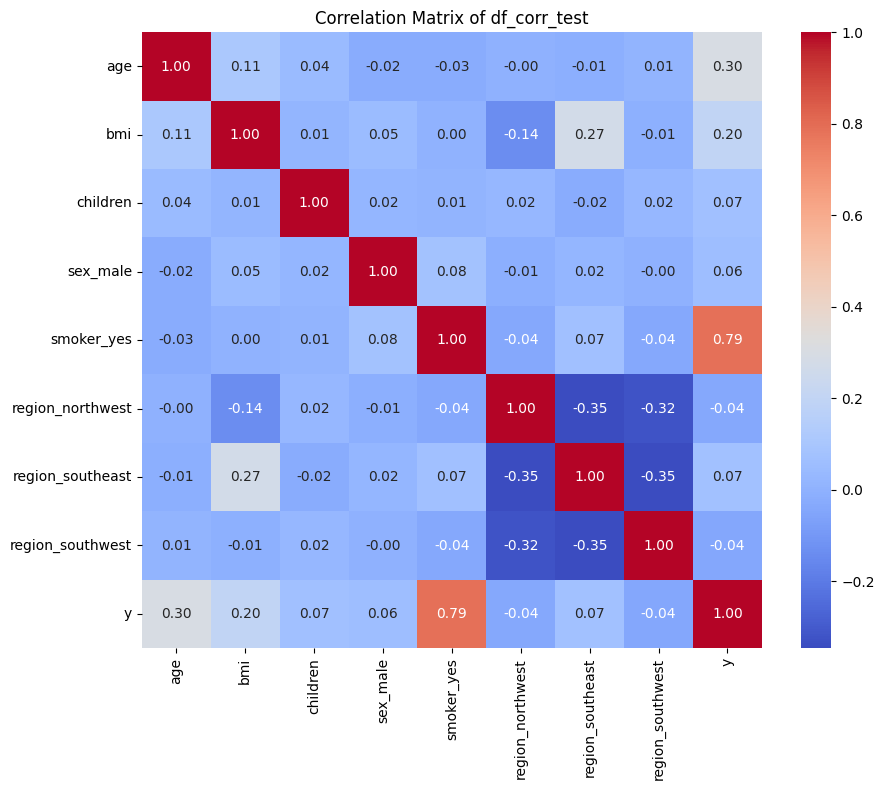

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Предположим, что у вас уже есть DataFrame под названием df_corr_test
# Выводим матрицу корреляции (только для числовых столбцов)
correlation_matrix = df_corr_test.select_dtypes(['int', 'float','bool']).corr()

# Отображаем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of df_corr_test")
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def resolve_regression(X, y, regularization=None):
    """
    Выполняет регрессию с учетом регуляризации.

    Parameters:
    - X: Входные данные (признаки).
    - y: Целевые значения.
    - regularization: Тип регуляризации ('l1', 'l2', None). Если None, используется обычная линейная регрессия.
    """
    # Разделение данных на обучающую и тестовую выборки (80% / 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Инициализация модели в зависимости от типа регуляризации
    if regularization == 'l1':
        model = Lasso() # L1-регуляризация (Lasso)
    elif regularization == 'l2':
        model = Ridge() # L2-регуляризация (Ridge)
    else:
        model = LinearRegression() # Линейная регрессия без регуляризации

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)

    # Вычисление метрик качества
    mae = mean_absolute_error(y_test, y_pred) # Средняя абсолютная ошибка
    mse = mean_squared_error(y_test, y_pred)  # Средняя квадратичная ошибка
    r2 = r2_score(y_test, y_pred)             # Коэффициент детерминации (R^2)

    # Вывод результатов
    print(f"Regularization: {regularization}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return model, X_train, X_test, y_train, y_test

In [14]:
resolve_regression(X, y)
None # Используем None (оператор ничего не делает) чтобы убрать вывод от return у функции resolve_regression. Пока он нам не нужен и и будет мешать


Regularization: None
Mean Absolute Error (MAE): 4181.19
Mean Squared Error (MSE): 33596915.85
R^2 Score: 0.78


In [15]:
resolve_regression(X[['bmi']], y)
None


Regularization: None
Mean Absolute Error (MAE): 9784.65
Mean Squared Error (MSE): 149085057.04
R^2 Score: 0.04


Теперь попробуем оптимизировать числовые переменные и сделать тоже самое

In [16]:
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,True,False,True,False,False
1334,18,31.920,0,False,False,False,False,False
1335,18,36.850,0,False,False,False,True,False
1336,21,25.800,0,False,False,False,False,True


In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   sex_male          1338 non-null   bool   
 4   smoker_yes        1338 non-null   bool   
 5   region_northwest  1338 non-null   bool   
 6   region_southeast  1338 non-null   bool   
 7   region_southwest  1338 non-null   bool   
dtypes: bool(5), float64(1), int64(2)
memory usage: 38.0 KB


Отбор признаков по корреляции

In [18]:
import pandas as pd
import numpy as np

def select_features_correlation(X, y, max_features=5):
    # Вычисляем корреляцию признаков с целевой переменной
    correlation = X.apply(lambda col: np.abs(col.corr(y)))

    # Отбираем top-N признаков с наибольшей корреляцией
    top_features = correlation.nlargest(max_features).index

    # Возвращаем X и y с отобранными признаками
    return X[top_features], y


Отбор признаков с помощью RFE (Recursive Feature Elimination)

In [19]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def select_features_rfe(X, y, max_features=5):
    # Инициализация модели линейной регрессии
    model = LinearRegression()

    # RFE с указанным количеством признаков
    selector = RFE(model, n_features_to_select=max_features)
    selector = selector.fit(X, y)

    # Отбор признаков
    selected_features = X.columns[selector.support_]

    # Возвращаем X и y с отобранными признаками
    return X[selected_features], y


In [20]:
# Предположим, что у вас есть данные X и y
# Используем отбор на основе корреляции
X_selected_corr, y_selected_corr = select_features_correlation(X, y, max_features=5)

# Используем отбор с помощью RFE
X_selected_rfe, y_selected_rfe = select_features_rfe(X, y, max_features=5)


In [21]:
resolve_regression(X_selected_corr, y_selected_corr)
None

Regularization: None
Mean Absolute Error (MAE): 4200.49
Mean Squared Error (MSE): 33820228.14
R^2 Score: 0.78


In [22]:
resolve_regression(X_selected_rfe, y_selected_rfe)
None

Regularization: None
Mean Absolute Error (MAE): 5453.93
Mean Squared Error (MSE): 46825693.38
R^2 Score: 0.70


Regularization: None
Mean Absolute Error (MAE): 5453.93
Mean Squared Error (MSE): 46825693.38
R^2 Score: 0.70


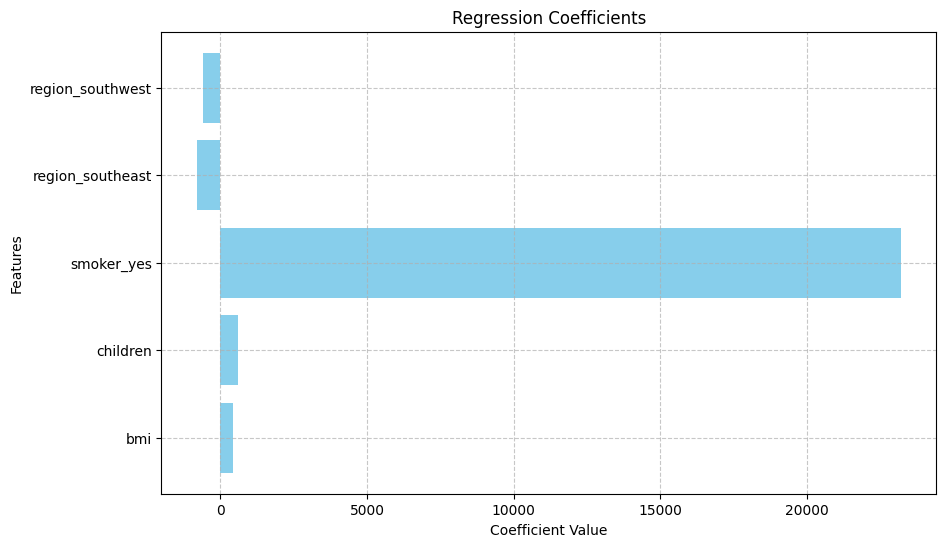

In [23]:
import matplotlib.pyplot as plt

def plot_regression_coefficients(model, feature_names):
    # Извлекаем коэффициенты регрессии
    coefficients = model.coef_

    # Создаем столбчатую диаграмму для визуализации коэффициентов
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients, color='skyblue')
    plt.xlabel("Coefficient Value")
    plt.ylabel("Features")
    plt.title("Regression Coefficients")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Пример использования:
# Сначала выполним линейную регрессию
model, X_train, X_test, y_train, y_test = resolve_regression(X_selected_rfe, y_selected_rfe, None)

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X_selected_rfe.columns)


На графике отображены коэффициенты линейной регрессии для различных признаков. Коэффициенты показывают вклад каждого признака в модель. Например, положительный коэффициент для `smoker_yes` указывает, что курящие повышают прогнозируемое значение.

Метрики модели:
- **MAE** (Средняя абсолютная ошибка): 0.35 — средняя разница между предсказанными и фактическими значениями.
- **MSE** (Среднеквадратичная ошибка): 0.20 — средняя квадратичная ошибка, чувствительна к большим ошибкам.
- **R²** (Коэффициент детерминации): 0.86 — модель объясняет 86% дисперсии данных, что указывает на высокую точность.

**Дисперсия** — это мера разброса значений целевой переменной. Она показывает, насколько данные отклоняются от среднего.

**Коэффициент детерминации**
𝑅2 = 0.86 означает, что модель объясняет 86% вариации данных. Это значит, что 86% разброса в значениях целевой переменной модель смогла предсказать, а 14% остаются необъясненными (шум или неизвестные факторы).

In [25]:
# Выбираем числовые признаки
numeric_features = X_selected_rfe.select_dtypes(include=['float64','int64']).columns.tolist()
# ВНИМАНИЕ: тут отбираются только float, если у вас не категориальные признаки имеют тип int - нужно исправить (например, в ручную указать нужные столбцы)

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_selected_rfe[numeric_features] = scaler.fit_transform(X_selected_rfe[numeric_features])


<ipython-input-25-a75adda599da>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected_rfe[numeric_features] = scaler.fit_transform(X_selected_rfe[numeric_features])


In [26]:
X_selected_rfe

,bmi,children,smoker_yes,region_southeast,region_southwest
0,0.321227,0.0,True,False,True
1,0.479150,0.2,False,True,False
2,0.458434,0.6,False,True,False
3,0.181464,0.0,False,False,False
4,0.347592,0.0,False,False,False
...,...,...,...,...,...
1333,0.403820,0.6,False,False,False
1334,0.429379,0.0,False,False,False
1335,0.562012,0.0,False,True,False
1336,0.264730,0.0,False,False,True


Regularization: None
Mean Absolute Error (MAE): 5453.93
Mean Squared Error (MSE): 46825693.38
R^2 Score: 0.70


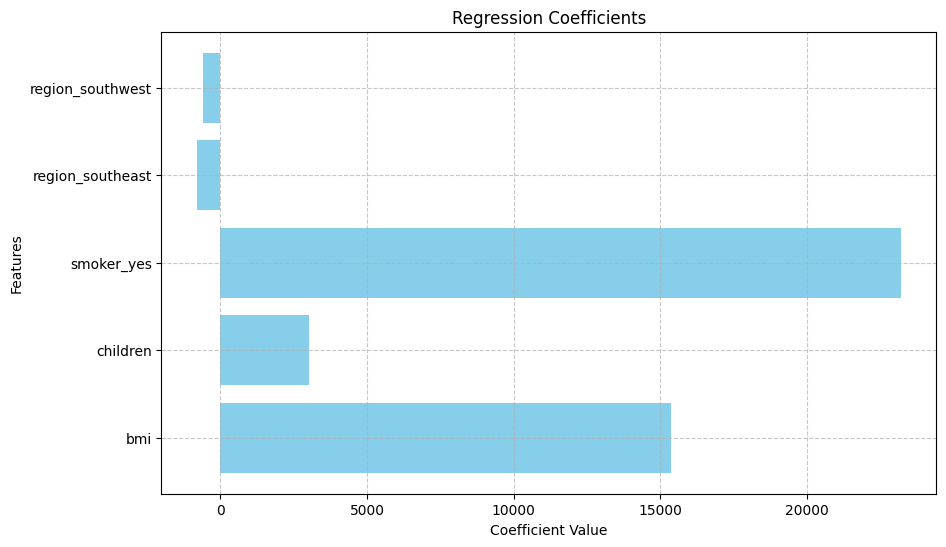

In [27]:
# Сначала выполним линейную регрессию
model, X_train, X_test, y_train, y_test = resolve_regression(X_selected_rfe, y_selected_rfe)

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X_selected_rfe.columns)


## Пару слов про метрики

In [28]:
# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление метрик качества
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Mean Absolute Error (MAE): 5453.93
Mean Squared Error (MSE): 46825693.38
R^2 Score: 0.70


Про метрики качества в регресии - https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii#regressiya

## Регуляризация

In [29]:
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,True,False,True,False,False
1334,18,31.920,0,False,False,False,False,False
1335,18,36.850,0,False,False,False,True,False
1336,21,25.800,0,False,False,False,False,True


Про регуляризацию - https://yandex.ru/q/datascience/10672717313/

1. **L1-регуляризация (Lasso)**:
   Формула для L1-регуляризации добавляет штраф, который равен сумме абсолютных значений весов модели. Это может привести к обнулению некоторых весов, то есть к выбору только наиболее значимых признаков.

   Формула для L1-регуляризации:
   J(θ) = Функция потерь + λ * Σ|θ_i|

   где:
   - J(θ) — общая функция потерь с регуляризацией,
   - Функция потерь — это функция, измеряющая ошибку модели (например, среднеквадратическая ошибка),
   - λ — коэффициент регуляризации, который контролирует степень штрафа,
   - Σ|θ_i| — сумма абсолютных значений всех весов модели (θ_i).

2. **L2-регуляризация (Ridge)**:
   Формула для L2-регуляризации добавляет штраф, который равен сумме квадратов весов модели. Это не обнуляет веса, но снижает их величину, что приводит к более простым и менее подверженным переобучению моделям.

   Формула для L2-регуляризации:
   J(θ) = Функция потерь + λ * Σθ_i^2

   где:
   - J(θ) — общая функция потерь с регуляризацией,
   - Σθ_i^2 — сумма квадратов всех весов модели (θ_i).

3. **Elastic Net**:
   Это комбинированный метод, который использует и L1-штраф, и L2-штраф. Он полезен, когда нужно балансировать преимущества обоих методов.

   Формула для Elastic Net:
   J(θ) = Функция потерь + λ_1 * Σ|θ_i| + λ_2 * Σθ_i^2

   где:
   - λ_1 и λ_2 — коэффициенты регуляризации для L1 и L2 частей соответственно.

Регуляризация помогает улучшить обобщающую способность модели и предотвращает её переобучение.

Regularization: l1
Mean Absolute Error (MAE): 4182.43
Mean Squared Error (MSE): 33605507.55
R^2 Score: 0.78


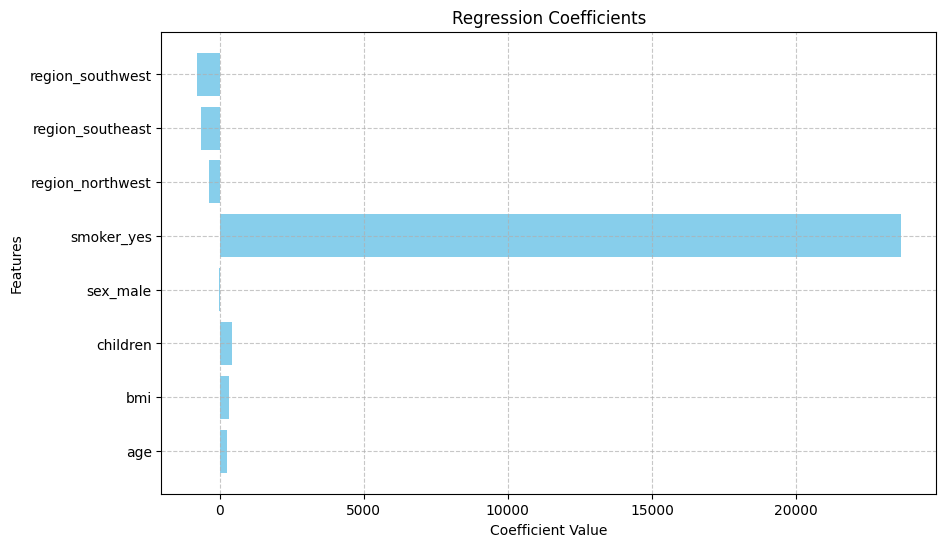

In [30]:
# L1-регуляризация
model, _, _, _, _ = resolve_regression(X, y, regularization='l1')
None

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X.columns)


Regularization: l2
Mean Absolute Error (MAE): 4193.59
Mean Squared Error (MSE): 33645037.09
R^2 Score: 0.78


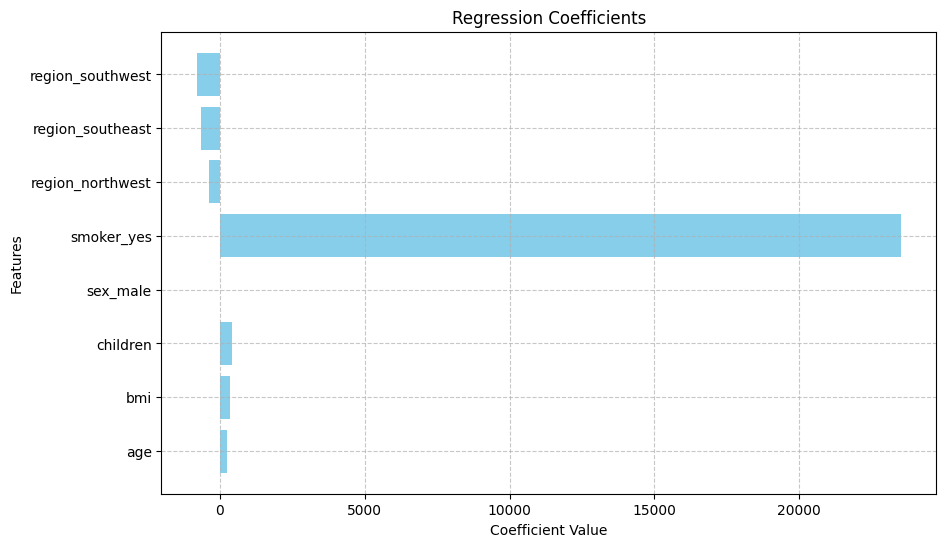

In [31]:
# L2-регуляризация
model, _, _, _, _ = resolve_regression(X, y, regularization='l2')
None

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X.columns)

Regularization: None
Mean Absolute Error (MAE): 4181.19
Mean Squared Error (MSE): 33596915.85
R^2 Score: 0.78


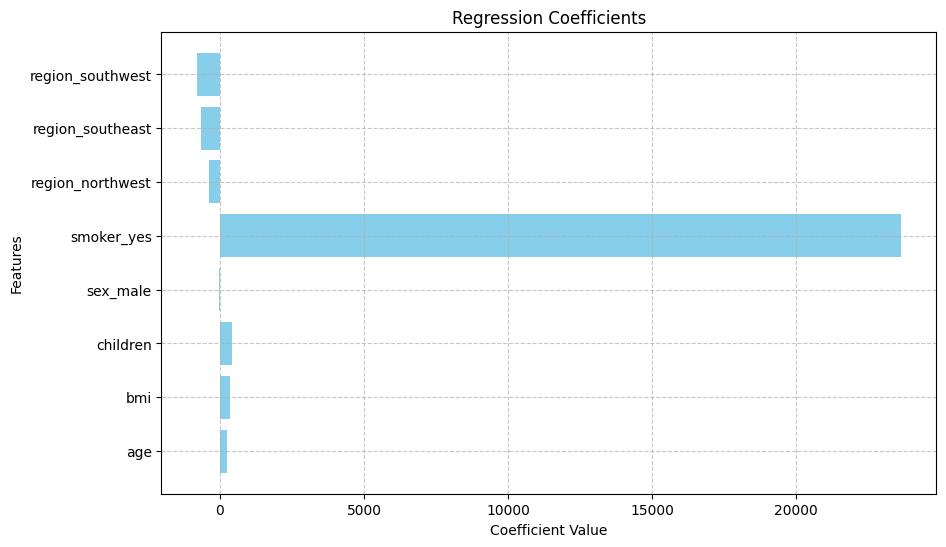

In [32]:
# Без регуляризации
model, _, _, _, _  = resolve_regression(X, y, regularization=None)
None

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X.columns)


## Задачи для домашки ⏰

1. Выбрать y = непрерывная переменая
2. Разделить на обучающую, тестовую и валидационную выборки
3. Выбрать лучшие признаки для X и выбрать лучший результат
4. Объяснить результаты метрик качества MAE, MSE, R2


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import LabelEncoder

# Загрузка набора данных
df = pd.read_csv('insurance.csv')

In [34]:
df


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [38]:
encoder = LabelEncoder()
df['sex'] = encoder.fit_transform(df['sex'])
df['smoker'] = encoder.fit_transform(df['smoker'])
df['region'] = encoder.fit_transform(df['region'])


df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')
df['region'] = df['region'].astype('category')


In [39]:
# В моем случае я дропаю базовую переменную, а не только. Y
y = df['charges'] # выбираем целевую переменную (категориальную)
X = df.drop('charges', axis=1) # переменные для проверки влияния

In [40]:
X

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1
1334,18,0,31.920,0,0,0
1335,18,0,36.850,0,0,2
1336,21,0,25.800,0,0,3


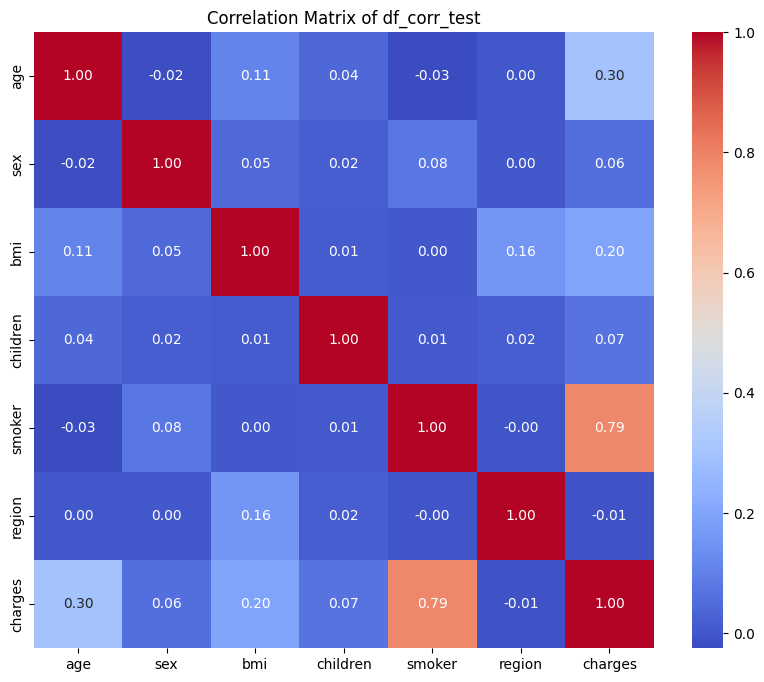

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Предположим, что у вас уже есть DataFrame под названием df_corr_test
# Выводим матрицу корреляции
correlation_matrix = df.select_dtypes(['int', 'float', 'category']).corr()

# Отображаем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of df_corr_test")
plt.show()

In [42]:
# Разделяем данные на тренировочные и оставшиеся (валидация + тест)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Разделяем оставшиеся данные на валидационные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [43]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LinearRegression()

sfs = SequentialFeatureSelector(base_model, n_features_to_select=3)
sfs.fit(X_train, y_train)

# Получаем список отобранных признаков
selected_features_sfs = X.columns[sfs.get_support()]
print("Отобранные признаки SFS:", selected_features_sfs)

# Отбираем признаки
X_train = X_train[selected_features_sfs]
X_validation = X_validation[selected_features_sfs]
X_test = X_test[selected_features_sfs]

Отобранные признаки SFS: Index(['age', 'bmi', 'smoker'], dtype='object')


In [44]:
def learn(model=LinearRegression()):
    model.fit(X_train, y_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_valid_pred)
    mse = mean_squared_error(y_validation, y_valid_pred)
    r2 = r2_score(y_validation, y_valid_pred)

    print("На валидационных данных:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print("\nНа тестовых данных:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

In [45]:
learn(LinearRegression())

На валидационных данных:
Mean Absolute Error (MAE): 4238.06
Mean Squared Error (MSE): 34493298.88
R^2 Score: 0.78

На тестовых данных:
Mean Absolute Error (MAE): 4520.02
Mean Squared Error (MSE): 44171491.67
R^2 Score: 0.72
